### Project Goal: Spam Email Detector

In this project, I will implement several **classical machine learning algorithms** to predict whether an email is classified as **spam** or **ham**. The primary objectives are to:

- Develop an effective classifier that accurately identifies unsolicited and potentially malicious emails.
- Enhance the user experience by reducing inbox clutter from spam messages.
- Improve overall email security by filtering out harmful content.

Through this approach, I aim to create a reliable tool for email classification.

# Import Libraries

In [1]:
import pandas as pd       # For data manipulation and analysis
import numpy as np        # For numerical operations
import matplotlib.pyplot as plt  # For basic data visualization
import seaborn as sns     # For enhanced data visualization
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix  # For model evaluation
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier  # Ensemble models
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors model
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
import re  # For regular expressions during text preprocessing
from nltk.corpus import stopwords  # For stop words removal
from nltk.stem import PorterStemmer  # For stemming
import nltk  # For natural language processing tasks

# Load Data

In [2]:
data = pd.read_csv('emails.csv')

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Quality Assessment

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
data.isna().sum()

,0
Category,0
Message,0


In [6]:
data.duplicated().sum()

415

In [7]:
data.drop_duplicates(inplace=True)

In [8]:
data.duplicated().sum()

0

In [9]:
data.shape

(5157, 2)

In [10]:
data.describe().T

,count,unique,top,freq
Category,5157,2,ham,4516
Message,5157,5157,"Go until jurong point, crazy.. Available only ...",1


In [11]:
data['Message_length'] = data['Message'].apply(len)

In [12]:
data[['Message_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
Message_length,5157.0,79.103936,58.382922,2.0,36.0,61.0,118.0,910.0


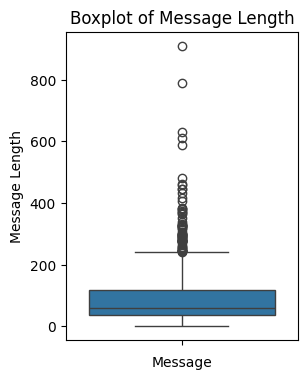

In [13]:
plt.figure(figsize=(3, 4))
sns.boxplot(data['Message_length'])
plt.title("Boxplot of Message Length")
plt.xlabel("Message")
plt.ylabel("Message Length")
plt.show()

# Text Preprocessing

## Convert Text to Lowercase

In [14]:
data['Message'] = data['Message'].str.lower()

In [15]:
data['Message'].head()

,Message
0,"go until jurong point, crazy.. available only ..."
1,ok lar... joking wif u oni...
2,free entry in 2 a wkly comp to win fa cup fina...
3,u dun say so early hor... u c already then say...
4,"nah i don't think he goes to usf, he lives aro..."


## Removing Punctuation and Special Characters.

In [16]:
def remove_punctuation(message):
    # Use regex to remove anything that is not a letter or space
    return re.sub(r'[^a-zA-Z\s]', '', message)

# The regex r'[^a-zA-Z\s]' matches any character that is not a letter
# (both uppercase and lowercase) or a whitespace.
# The re.sub() function replaces these characters with an empty string,
# effectively removing them.

In [17]:
data['Message'] = data['Message'].apply(remove_punctuation)

In [18]:
data['Message'].head()

,Message
0,go until jurong point crazy available only in ...
1,ok lar joking wif u oni
2,free entry in a wkly comp to win fa cup final...
3,u dun say so early hor u c already then say
4,nah i dont think he goes to usf he lives aroun...


## Tokenization

In [19]:
def tokenize_text(text):
    # Split the text into words (tokens)
    return text.split()

In [20]:
data['tokens'] = data['Message'].apply(tokenize_text)

In [21]:
data[['Message', 'tokens']].head()

,Message,tokens
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


## Stemming

Stemming is the process of reducing words to their root or base form. This helps in consolidating different forms of a word (e.g., "running" becomes "run") and reduces the dimensionality of the dataset, which can be beneficial for model performance.

In [22]:
# Initialize the stemmer
stemmer = PorterStemmer()

In [23]:
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

In [24]:
data['stemmed_tokens'] = data['tokens'].apply(stem_tokens)

In [25]:
data[['tokens', 'stemmed_tokens']].head()

,tokens,stemmed_tokens
0,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ..."
3,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, earli, hor, u, c, alreadi, t..."
4,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goe, to, usf, he, li..."


## Remove Stop Words

Stop words are common words (such as "and," "the," "is," etc.) that typically do not carry significant meaning and are often removed during text preprocessing. Removing stop words helps to reduce noise in the data, focusing on the more meaningful words.

In [26]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
# Function to remove stop words from tokens
def remove_stop_words(tokens):
    return [token for token in tokens if token not in stop_words]

In [29]:
data['final_tokens'] = data['stemmed_tokens'].apply(remove_stop_words)

In [30]:
data[['stemmed_tokens', 'final_tokens']].head()

,stemmed_tokens,final_tokens
0,"[go, until, jurong, point, crazi, avail, onli,...","[go, jurong, point, crazi, avail, onli, bugi, ..."
1,"[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entri, in, a, wkli, comp, to, win, fa, ...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,"[u, dun, say, so, earli, hor, u, c, alreadi, t...","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"[nah, i, dont, think, he, goe, to, usf, he, li...","[nah, dont, think, goe, usf, live, around, tho..."


## Text Vectorization

Text vectorization is the process of converting text data into numerical form so that machine learning algorithms can process it. One common method for vectorization is the TF-IDF (Term Frequency-Inverse Document Frequency) technique, which reflects how important a word is to a document in a collection or corpus.

In [31]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split(), lowercase=False, max_features=5000)

In [32]:
# Convert final_tokens back to a space-separated string for vectorization
data['final_text'] = data['final_tokens'].apply(lambda x: ' '.join(x))

In [33]:
# Fit and transform the data
X = vectorizer.fit_transform(data['final_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [34]:
X.shape

(5157, 5000)

# Encoding the Target Variable

In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(data['Category'])

In [36]:
label_encoder.classes_

array(['ham', 'spam'], dtype=object)

In [37]:
y_encoded

array([0, 0, 1, ..., 0, 0, 0])

# Data Splitting

In [38]:
X = vectorizer.transform(data['final_text'])
y = y_encoded

In [39]:
X.shape, y.shape

((5157, 5000), (5157,))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training set shape: (4125, 5000)
Testing set shape: (1032, 5000)
Training labels shape: (4125,)
Testing labels shape: (1032,)


# Modeling

In [41]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Training Predictions
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    cm_train = confusion_matrix(y_train, y_train_pred)

    # Testing Predictions
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Print Training Results
    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Training F1 Score: {train_f1:.2f}")
    print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred)}")

    # Plot Training Confusion Matrix
    plot_confusion_matrix(cm_train, f"{model_name} (Training)")

    # Print Testing Results
    print(f"{model_name} Testing Accuracy: {test_accuracy:.2f}")
    print(f"{model_name} Testing F1 Score: {test_f1:.2f}")
    print(f"Test Classification Report:\n{classification_report(y_test, y_test_pred)}")

    # Plot Testing Confusion Matrix
    plot_confusion_matrix(cm_test, f"{model_name} (Testing)")

## LogisticRegression

In [43]:
logistic_model = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')

In [44]:
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Logistic Regression Training Accuracy: 0.97
Logistic Regression Training F1 Score: 0.96
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3612
           1       0.99      0.73      0.84       513

    accuracy                           0.97      4125
   macro avg       0.98      0.87      0.91      4125
weighted avg       0.97      0.97      0.96      4125



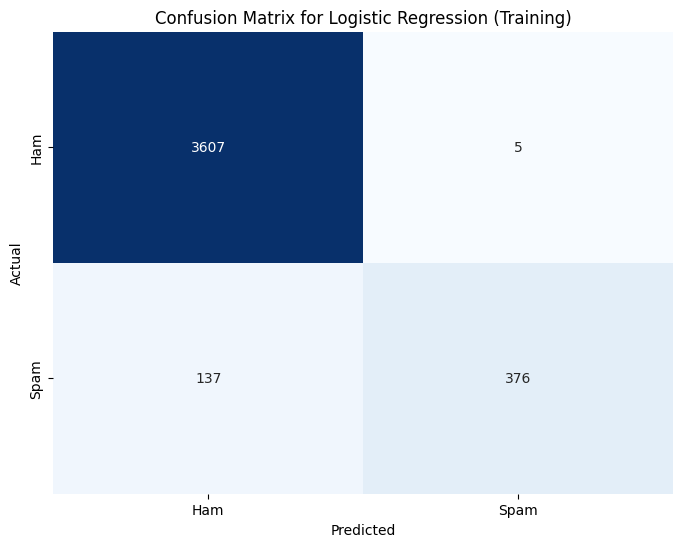

Logistic Regression Testing Accuracy: 0.96
Logistic Regression Testing F1 Score: 0.95
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       904
           1       0.97      0.68      0.80       128

    accuracy                           0.96      1032
   macro avg       0.96      0.84      0.89      1032
weighted avg       0.96      0.96      0.95      1032



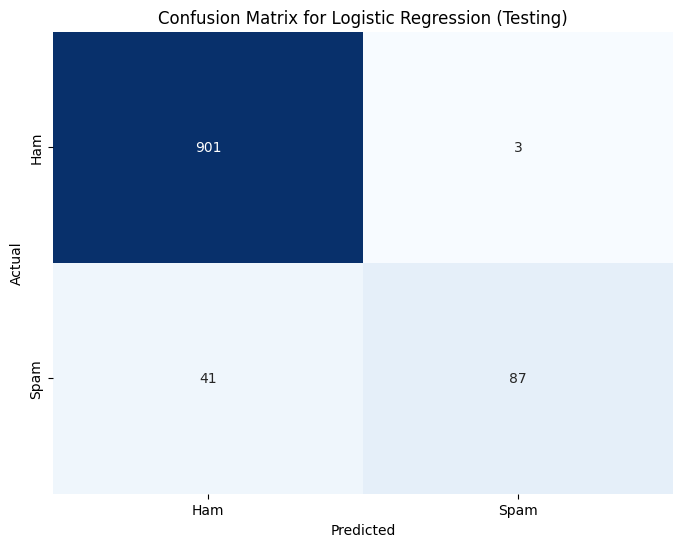

In [45]:
# Evaluate Logistic Regression
evaluate_model(logistic_model, X_train, y_train, X_test, y_test, "Logistic Regression")

## Random Forest Classifier

In [46]:
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42, max_features=0.9)

In [47]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, max_features=0.9, random_state=42)

Random Forest Classifier Training Accuracy: 0.99
Random Forest Classifier Training F1 Score: 0.99
Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3612
           1       1.00      0.92      0.96       513

    accuracy                           0.99      4125
   macro avg       0.99      0.96      0.98      4125
weighted avg       0.99      0.99      0.99      4125



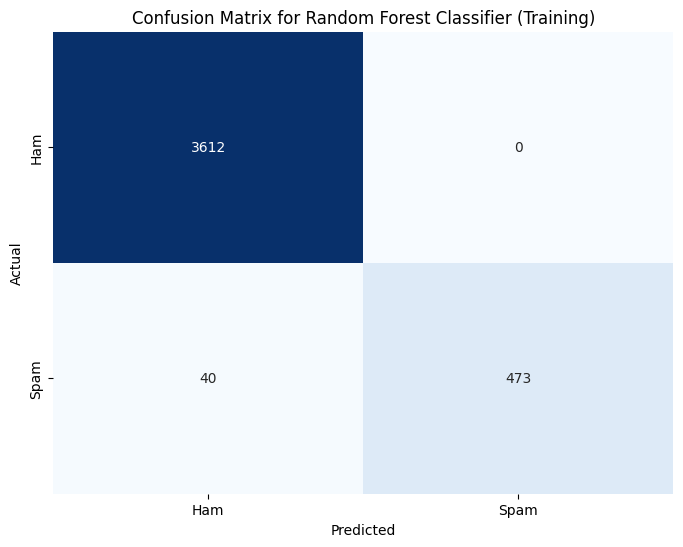

Random Forest Classifier Testing Accuracy: 0.95
Random Forest Classifier Testing F1 Score: 0.95
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       904
           1       0.86      0.74      0.80       128

    accuracy                           0.95      1032
   macro avg       0.91      0.86      0.89      1032
weighted avg       0.95      0.95      0.95      1032



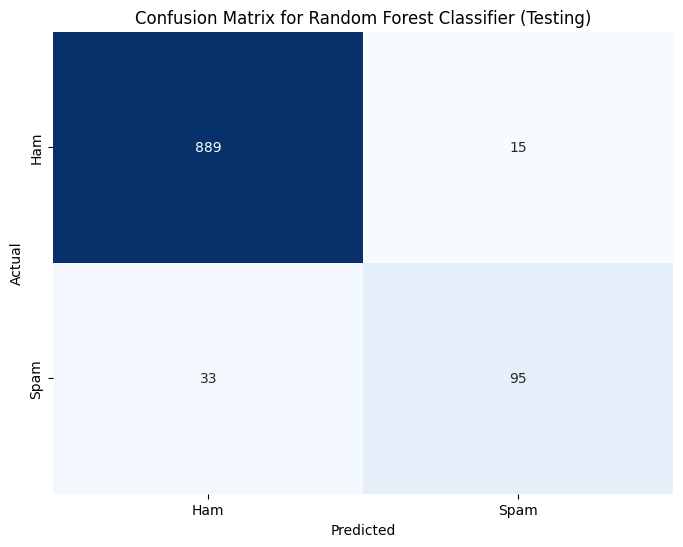

In [48]:
# Evaluate Random Forest Classifier
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test, "Random Forest Classifier")

## AdaBoost Classifier

In [49]:
adaboost_model = AdaBoostClassifier(n_estimators=250, algorithm='SAMME', random_state=42)

In [50]:
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=250, random_state=42)

AdaBoost Classifier Training Accuracy: 0.96
AdaBoost Classifier Training F1 Score: 0.95
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3612
           1       0.91      0.72      0.80       513

    accuracy                           0.96      4125
   macro avg       0.94      0.85      0.89      4125
weighted avg       0.96      0.96      0.95      4125



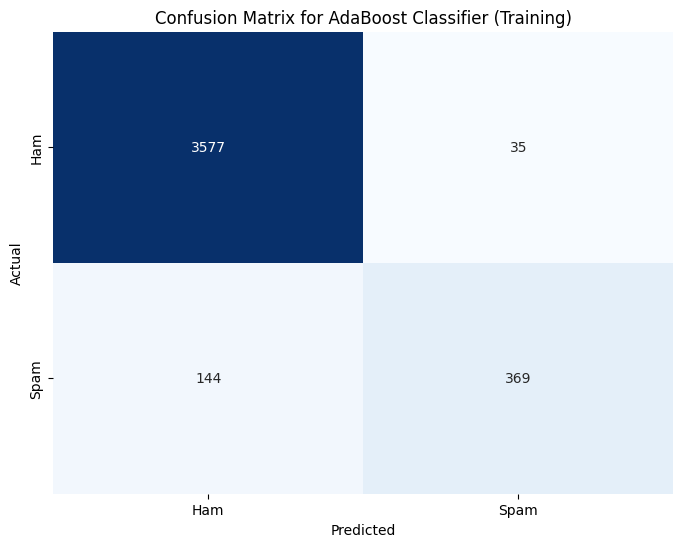

AdaBoost Classifier Testing Accuracy: 0.95
AdaBoost Classifier Testing F1 Score: 0.94
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       904
           1       0.88      0.65      0.75       128

    accuracy                           0.95      1032
   macro avg       0.92      0.82      0.86      1032
weighted avg       0.94      0.95      0.94      1032



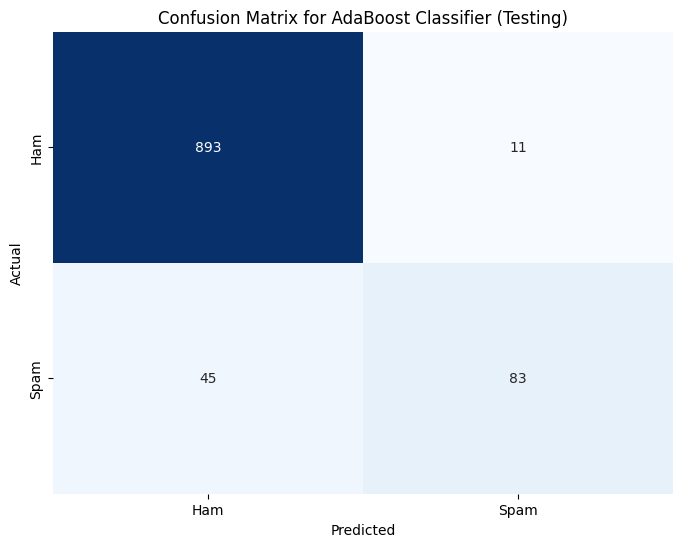

In [51]:
# Evaluate AdaBoost Classifier
evaluate_model(adaboost_model, X_train, y_train, X_test, y_test, "AdaBoost Classifier")

## K-Nearest Neighbors

In [52]:
k = 3
knn_model = KNeighborsClassifier(n_neighbors=k)

In [53]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

K-Nearest Neighbors Training Accuracy: 0.94
K-Nearest Neighbors Training F1 Score: 0.94
Train Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3612
           1       1.00      0.55      0.71       513

    accuracy                           0.94      4125
   macro avg       0.97      0.77      0.84      4125
weighted avg       0.95      0.94      0.94      4125



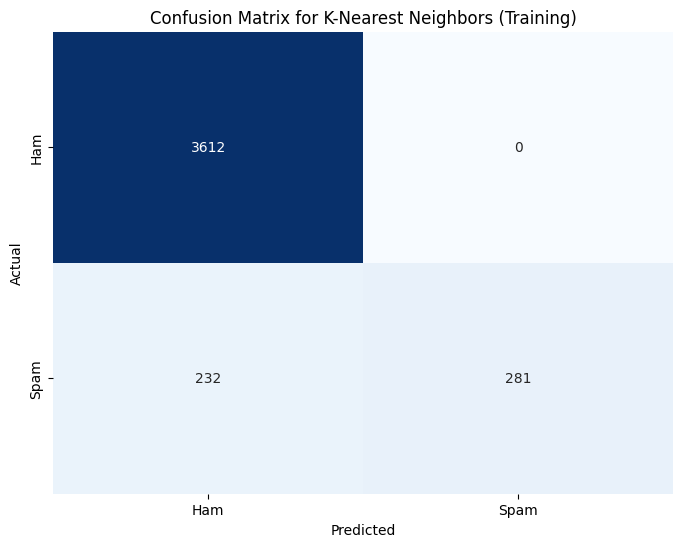

K-Nearest Neighbors Testing Accuracy: 0.93
K-Nearest Neighbors Testing F1 Score: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       904
           1       1.00      0.41      0.58       128

    accuracy                           0.93      1032
   macro avg       0.96      0.70      0.77      1032
weighted avg       0.93      0.93      0.91      1032



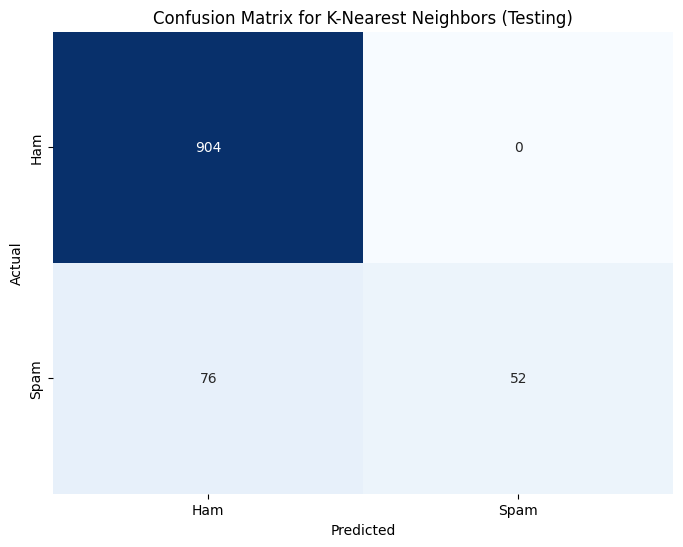

In [54]:
evaluate_model(knn_model, X_train, y_train, X_test, y_test, "K-Nearest Neighbors")